In [23]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
#============================================
# Camera calibration
#============================================
#Define size of chessboard target.
chessboard_size = (7,5)

In [24]:
from matplotlib import pyplot as plt

## Camera Calibration

In [3]:
#Define arrays to save detected points
obj_points = [] #3D points in real world space 
img_points = [] #3D points in image plane
#Prepare grid and points to display
objp = np.zeros((np.prod(chessboard_size),3),dtype=np.float32)
objp[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)

In [4]:
calibration_paths = glob.glob('Calibration_images/*')

In [ ]:
#read images
calibration_paths = glob.glob('Calibration_images/*')
#Iterate over images to find intrinsic matrix
for image_path in tqdm(calibration_paths):
    image = cv2.imread(image_path)
    image = image.astype('uint8')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Image loaded, Analyzing...")
    ret,corners = cv2.findChessboardCorners(gray_image, chessboard_size, None)
    if ret == True:
        print("Chessboard detected!")
        print(image_path)
      #define criteria for subpixel accuracy
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
      #refine corner location (to subpixel accuracy) based on criteria.
        cv2.cornerSubPix(gray_image, corners, (5,5), (-1,-1), criteria)
        obj_points.append(objp)
        img_points.append(corners)

In [ ]:
#Calibrate camera
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,gray_image.shape[::-1], None, None)
#Save parameters into numpy file
np.save("camera_params/ret", ret)
np.save("camera_params/K", K)
np.save("camera_params/dist", dist)
np.save("camera_params/rvecs", rvecs)
np.save("camera_params/tvecs", tvecs)

In [ ]:
#Get exif data in order to get focal length. 
exif_img = PIL.Image.open('Calibration_images/IMG_20190414_224445.jpg')
exif_data = {
          PIL.ExifTags.TAGS[k]:v
          for k, v in exif_img._getexif().items()
          if k in PIL.ExifTags.TAGS
}
#Get focal length in tuple form
focal_length_exif = exif_data['FocalLength']
#Get focal length in decimal form
focal_length = focal_length_exif[0]/focal_length_exif[1]
np.save("camera_params/FocalLength", focal_length)

In [25]:
#=========================================================
# Stereo 3D reconstruction 
#=========================================================
#Load camera parameters
ret = np.load('./camera_params/ret.npy')
K = np.load('./camera_params/K.npy')
dist = np.load('./camera_params/dist.npy')
#Specify image paths
img_path1 = 'cup/11.jpg'
img_path2 = 'cup/12.jpg'
im3 = 'cup/21.jpg'
im4 = 'cup/22.jpg'
im5 = 'cup/31.jpg'
im6 = 'cup/32.jpg'
#Load pictures
img_1 = cv2.imread(img_path1)
img_2 = cv2.imread(img_path2)
img_3 = cv2.imread(im3)
img_4 = cv2.imread(im4)
img_5 = cv2.imread(im5)
img_6 = cv2.imread(im6)
img_7 = cv2.imread('cup/41.jpg')
img_8 = cv2.imread('cup/42.jpg')
img_9 = cv2.imread('cup/51.jpg')
img_10 = cv2.imread('cup/52.jpg')
img_11 = cv2.imread('cup/61.jpg')
img_12 = cv2.imread('cup/62.jpg')
#Get height and width. Note: It assumes that both pictures are the same size. They HAVE to be same size 
h,w = img_2.shape[:2]

In [26]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [27]:
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image

In [28]:
#Get optimal camera matrix for better undistortion 
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))
#Undistort images
img_1_undistorted = cv2.undistort(img_1, K, dist, None, new_camera_matrix)
img_2_undistorted = cv2.undistort(img_2, K, dist, None, new_camera_matrix)
img_3_undistorted = cv2.undistort(img_3, K, dist, None, new_camera_matrix)
img_4_undistorted = cv2.undistort(img_4, K, dist, None, new_camera_matrix)
img_5_undistorted = cv2.undistort(img_5, K, dist, None, new_camera_matrix)
img_6_undistorted = cv2.undistort(img_6, K, dist, None, new_camera_matrix)
img_7_undistorted = cv2.undistort(img_7, K, dist, None, new_camera_matrix)
img_8_undistorted = cv2.undistort(img_8, K, dist, None, new_camera_matrix)
img_9_undistorted = cv2.undistort(img_9, K, dist, None, new_camera_matrix)
img_10_undistorted = cv2.undistort(img_10, K, dist, None, new_camera_matrix)
img_11_undistorted = cv2.undistort(img_11, K, dist, None, new_camera_matrix)
img_12_undistorted = cv2.undistort(img_12, K, dist, None, new_camera_matrix)
#Downsample each image 3 times (because they're too big)
img_1_downsampled = downsample_image(img_1_undistorted,3)
img_2_downsampled = downsample_image(img_2_undistorted,3)
img_3_downsampled = downsample_image(img_3_undistorted,3)
img_4_downsampled = downsample_image(img_4_undistorted,3)
img_5_downsampled = downsample_image(img_5_undistorted,3)
img_6_downsampled = downsample_image(img_6_undistorted,3)
img_7_downsampled = downsample_image(img_7_undistorted,3)
img_8_downsampled = downsample_image(img_8_undistorted,3)
img_9_downsampled = downsample_image(img_9_undistorted,3)
img_10_downsampled = downsample_image(img_10_undistorted,3)
img_11_downsampled = downsample_image(img_11_undistorted,3)
img_12_downsampled = downsample_image(img_12_undistorted,3)

In [29]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 5,
 uniquenessRatio = 5,
 speckleWindowSize = 5,
 speckleRange = 5,
 disp12MaxDiff = 1,
 P1 = 8*3*win_size**2,#8*3*win_size**2,
 P2 =32*3*win_size**2) #32*3*win_size**2)


Computing the disparity  map...


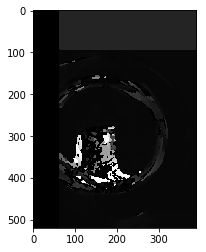

In [30]:
#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map1 = stereo.compute(img_1_downsampled, img_2_downsampled)
disparity_map2 = stereo.compute(img_3_downsampled, img_4_downsampled)
disparity_map3 = stereo.compute(img_5_downsampled, img_6_downsampled)
disparity_map4 = stereo.compute(img_7_downsampled, img_8_downsampled)
disparity_map5 = stereo.compute(img_9_downsampled, img_10_downsampled)
disparity_map6 = stereo.compute(img_11_downsampled, img_12_downsampled)
#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map1,'gray')
plt.show()

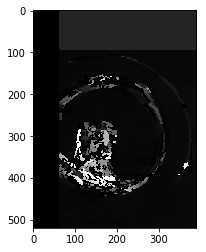

In [31]:
plt.imshow(disparity_map4,'gray')
plt.show()

In [ ]:
plt.imshow(disparity_map5,'gray')
plt.show()

In [32]:
def gen_points(i1, i2, disparity_map):
    h,w = i1.shape[:2]
    #Load focal length. 
    focal_length = np.load('./camera_params/FocalLength.npy')
    #Perspective transformation matrix
    #This transformation matrix is from the openCV documentation, didn't seem to work for me. 
    Q = np.float32([[1,0,0,-w/2.0],
        [0,-1,0,h/2.0],
        [0,0,0,-focal_length],
        [0,0,1,0]])
    #This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision. 
    #Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
    Q2 = np.float32([[1,0,0,0],
        [0,-1,0,0],
        [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally. 
        [0,0,0,1]])
    #Reproject points into 3D
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q2)
    colors = cv2.cvtColor(i2, cv2.COLOR_BGR2RGB)
    mask_map = disparity_map > disparity_map.min()
    output_points = points_3D[mask_map]
    output_colors = colors[mask_map]
    return output_points, output_colors

In [33]:
output_points1, output_colors1 = gen_points(img_1_downsampled, img_2_downsampled, disparity_map1)
output_points2, output_colors2 = gen_points(img_3_downsampled, img_4_downsampled, disparity_map2)
output_points3, output_colors3 = gen_points(img_5_downsampled, img_6_downsampled, disparity_map3)
output_points4, output_colors4 = gen_points(img_7_downsampled, img_8_downsampled, disparity_map4)
output_points5, output_colors5 = gen_points(img_9_downsampled, img_10_downsampled, disparity_map5)
output_points6, output_colors6 = gen_points(img_11_downsampled, img_12_downsampled, disparity_map6)

In [34]:
output_points = np.concatenate((output_points1,output_points2), axis=0)
output_points = np.concatenate((output_points,output_points3), axis=0)
output_points = np.concatenate((output_points,output_points4), axis=0)
output_points = np.concatenate((output_points,output_points5), axis=0)
output_points = np.concatenate((output_points,output_points6), axis=0)
output_colors = np.concatenate((output_colors1,output_colors2), axis=0)
output_colors = np.concatenate((output_colors,output_colors3), axis=0)
output_colors = np.concatenate((output_colors,output_colors4), axis=0)
output_colors = np.concatenate((output_colors,output_colors5), axis=0)
output_colors = np.concatenate((output_colors,output_colors6), axis=0)
output_file = 'reconstructed_plot_speaker.ply'
#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points1, output_colors1, output_file)


 Creating the output file... 

